# Name Generator - Part 2

We wil be creating a multi-layer perceptron based on the following paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

We will create a 2D "embed" vector for each character `(27, 2)`, which the neural net will use to calculate how close certain characters are to others.

The first layer of the neural net will accept 6 inputs (3 characters * 2 dimensions). It will produce a non-linearity using tanh, resulting in numbers between -1 and 1. The size of this layer is somewhat configurable. In this example we'll set it to `100` neurons.

The second layer will produce a probability distribution for each character, and thus have 27 outputs.

![](bengio-mlp.png)

In [152]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Read in the list of names like before, see the first 8:

In [153]:
names = open('names.txt', 'r').read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

Build the integer/string mappings like before:

In [154]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Build the data set. In this case, the `X` will contain 3 characters, and `Y` will contain the expected next character.

In [155]:
block_size = 3 # context length: how many characters do we take to predict the next one?

X, Y = [], []

for name in names[:1]:
    context = [0] * block_size
    for ch in name + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .


In this case, the first name provides 5 different examples to our neural net. Because each example contains 3 characters, `X` is a `5, 3` matrix. `Y` contains the 5 answers, thus is vector of size `5`.

In [156]:
print(X)
print(X.shape)
print(Y)
print(Y.shape)

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])
torch.Size([5, 3])
tensor([ 5, 13, 13,  1,  0])
torch.Size([5])


Let's create the embed matrix, assigning 2 dimensions for each character, initialised to random values:

In [157]:
C = torch.randn((27, 2))
C

tensor([[ 0.9799,  0.8589],
        [ 1.4675,  0.2374],
        [ 1.6056,  1.0114],
        [ 1.6632,  1.4686],
        [ 1.2077, -0.3020],
        [-0.2764,  0.5290],
        [-0.7005,  0.1449],
        [ 2.3301,  0.3210],
        [ 0.9693,  0.1317],
        [-0.1643, -1.7947],
        [ 0.0177,  1.6816],
        [ 0.6011,  0.9666],
        [-0.1114, -1.3403],
        [ 0.5758, -0.1690],
        [-1.7757, -0.3478],
        [-0.9112,  1.0972],
        [-0.1917, -0.2253],
        [-0.9704,  0.6929],
        [-0.6358,  0.0104],
        [ 1.2627,  1.0486],
        [-0.8314, -0.6739],
        [-0.5770,  1.7260],
        [ 0.8120,  0.4480],
        [ 0.2051,  0.5867],
        [ 0.6907,  0.9118],
        [ 1.5045, -0.3153],
        [ 0.3842, -1.4103]])

We can fetch the embed matrix for our training set `X`:

In [158]:
embed = C[X]
print(embed.shape)
print(embed)

torch.Size([5, 3, 2])
tensor([[[ 0.9799,  0.8589],
         [ 0.9799,  0.8589],
         [ 0.9799,  0.8589]],

        [[ 0.9799,  0.8589],
         [ 0.9799,  0.8589],
         [-0.2764,  0.5290]],

        [[ 0.9799,  0.8589],
         [-0.2764,  0.5290],
         [ 0.5758, -0.1690]],

        [[-0.2764,  0.5290],
         [ 0.5758, -0.1690],
         [ 0.5758, -0.1690]],

        [[ 0.5758, -0.1690],
         [ 0.5758, -0.1690],
         [ 1.4675,  0.2374]]])


Observe that pytorch has created a `(5, 3, 2)` matrix, joining up the embed table for each example in `X`. For example, `0, 0, 0` has become:

```
[
  [-0.2467,  0.7721],
  [-0.2467,  0.7721],
  [-0.2467,  0.7721]
]
```

Let's now create the second, hidden layer:

In [159]:
W1 = torch.randn((6, 100)) # each example is 3 characters * 2 dimensions
b1 = torch.randn(100)

We want to simply matrix multiply our `embed` matrix with the weights `W1`, but they are of different shapes, where broadcasting will not work:

- `embed` is of shape (5, 3, 2)
- `W1` is of shape (6, 100)

We can use the `tensor.view` function from pytorch, which will efficiently re-arrange the tensor into the desired arrangement. We can view the existing `(5, 3, 2)` matrix as a `(5, 6)` matrix, which will squash the last 2 dimensions. The result would allow us to matrix multiply as the following is broadcastable:

`(5, 6) * (6, 100) = (5, 100)`

In [160]:
embed.view(5, 6)

tensor([[ 0.9799,  0.8589,  0.9799,  0.8589,  0.9799,  0.8589],
        [ 0.9799,  0.8589,  0.9799,  0.8589, -0.2764,  0.5290],
        [ 0.9799,  0.8589, -0.2764,  0.5290,  0.5758, -0.1690],
        [-0.2764,  0.5290,  0.5758, -0.1690,  0.5758, -0.1690],
        [ 0.5758, -0.1690,  0.5758, -0.1690,  1.4675,  0.2374]])

PyTorch is able to infer what the dimension should be if a `-1` is provided:

In [161]:
embed.view(-1, 6)

tensor([[ 0.9799,  0.8589,  0.9799,  0.8589,  0.9799,  0.8589],
        [ 0.9799,  0.8589,  0.9799,  0.8589, -0.2764,  0.5290],
        [ 0.9799,  0.8589, -0.2764,  0.5290,  0.5758, -0.1690],
        [-0.2764,  0.5290,  0.5758, -0.1690,  0.5758, -0.1690],
        [ 0.5758, -0.1690,  0.5758, -0.1690,  1.4675,  0.2374]])

Let's calculate the outputs of the first layer:

In [162]:
h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
h

tensor([[-0.8267, -0.5699, -0.9288,  0.9575,  0.8299,  0.9997, -0.4747, -1.0000,
          0.2539,  0.9982, -0.8216,  0.5354,  0.9946,  0.9975, -0.6350,  0.6338,
          0.9911, -0.9872,  0.9946,  0.4709, -0.9781,  0.9127, -0.4088,  0.3465,
         -0.9876, -0.9989, -0.9887, -0.9975,  0.9779,  0.8347, -0.9727, -0.7693,
          0.2632,  1.0000, -0.0578, -0.3172, -0.8612, -0.1866,  0.9992, -0.7984,
         -0.9910, -0.9191,  0.9997, -0.6888, -0.0566, -0.9432,  0.9567,  0.4622,
          0.9290, -0.0512,  0.5275,  1.0000,  0.4506, -0.8854, -0.0371, -0.9850,
          0.9791,  0.5580, -0.9744,  0.0797, -0.0988, -0.9998,  0.9579,  0.9467,
          0.3039,  0.9539, -0.9979,  0.9985, -0.9890, -0.0751,  0.9631,  0.1032,
          0.3154, -0.9508, -0.9885, -0.9929,  1.0000, -0.9842, -0.9995,  0.5695,
          0.9744,  0.8938,  0.9982,  0.9998, -0.9875, -0.5354,  0.1940, -0.9992,
         -0.7294,  0.9537, -0.9998, -0.9951,  0.9972, -0.0161, -0.9975,  0.8333,
         -0.6071, -0.9850,  

Let's create the second layer, which will take these values and produce a probability distribution of the 27 potential characters:

In [163]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
logits

tensor([[  2.5355,   1.4285,  -0.5554,   0.5025,  -4.0405,   5.7500, -10.8605,
         -20.8747,   1.6982,   0.3239,  -5.0862, -12.6389, -11.3005,   4.6717,
          -7.1378,  -3.0151,  10.0648,   2.8783,   2.2600, -15.3109,   2.6002,
          -0.5761,  -2.5086,   4.3347,  -0.2843,  18.3531,   5.2250],
        [  3.8994,  -6.2994,  -4.7015,  -7.3717,   5.7893,  -0.6632, -28.3738,
          -9.2037,  -2.4826,   4.3282, -12.4050, -15.4718,  -5.3029,  -2.3148,
         -11.6994,  -9.9921,   4.0407,   8.6430,  -2.4585, -14.0408,   0.3474,
          -0.1287,  -5.5822,   8.9143,  -1.6870,  13.2154,   6.9671],
        [ -1.1802,   0.5486,  -0.6542,  -3.6250,  10.1093,  -3.3995,  -7.5130,
         -11.2209,   6.9735,   0.9617,  -7.0510,  -1.8003,   3.1685,   4.2005,
          -5.9783,  -2.8004,  12.9170,   3.5407,   3.7506,  -8.5992,  -4.4883,
           9.3374,   0.7267,  -5.7790,   4.6904,  15.4639,   2.1483],
        [ -1.8510,   8.1809,  -9.6048, -15.1806,   8.0927,   8.0946,  -4.4072,


In the previous example, we calculated the loss from the logits by manually calculating the negative log likelihood. Pytorch provides this classification function: https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy.

Let's see what is the loss of the neural net, based on the one example we have given it:

In [164]:
loss = F.cross_entropy(logits, Y)
loss

tensor(14.4954)

In [165]:
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

Our neural network has the following number of parameters:

In [166]:
sum(p.nelement() for p in parameters)

3481

Let's train our neural net on the same single example:

In [167]:
for i in range(50):
    
    # forward pass
    embed = C[X]
    h = torch.tanh(embed.view(5, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    if i % 5 == 0:
        print(f'{i}: {loss.item()}')
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.01 * p.grad

0: 14.495404243469238
5: 6.779103755950928
10: 3.578019380569458
15: 1.853354811668396
20: 0.8765897750854492
25: 0.47485485672950745
30: 0.3122987747192383
35: 0.23300385475158691
40: 0.18684235215187073
45: 0.15659072995185852


Observe that the loss is very low. This is because our neural net has 3500 parameters, and only needs to squeeze in 5 example. It is "overfitting" the data.

Let's run the training again but on the entire dataset.

In [168]:
# create training set

block_size = 3
X, Y = [], []
for name in names:
    context = [0] * block_size
    for ch in name + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

# initialise net

C = torch.randn((27, 2))
embed = C[X]
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

Observe that the size of embed now contains 3 characters, with 2 dimensions, for 228,000 examples:

In [169]:
embed.shape

torch.Size([228146, 3, 2])

In [170]:
for i in range(50):
    
    # forward pass
    embed = C[X]
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    if i % 5 == 0:
        print(f'{i}: {loss.item()}')
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.01 * p.grad

0: 16.417057037353516
5: 15.704347610473633
10: 15.064451217651367
15: 14.476014137268066
20: 13.94002628326416
25: 13.455886840820312
30: 13.008109092712402
35: 12.585150718688965
40: 12.184182167053223
45: 11.805460929870605


Observe that computing the gradients for 228,000 examples for each pass is slow. Instead of using all the examples, it is better to pick a smaller batch of examples. This will reduce the quality of our gradient, but is still good enough. It is better to make many steps in roughly the right direction, than it is to take fewer steps in the right direction.

Let's amend our training loop. 

We will create a vector of 32 random integers between 0 and the number of examples, and index into our examples to create our batch.

In [171]:
print(X.shape)
num_examples = X.shape[0]
print(num_examples)

torch.Size([228146, 3])
228146


In [172]:
for i in range(50):
    ix = torch.randint(0, num_examples, (32,))
    
    # forward pass
    embed = C[X[ix]]
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    if i % 5 == 0:
        print(f'{i}: {loss.item()}')
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.01 * p.grad

0: 12.168842315673828
5: 10.076385498046875
10: 11.882920265197754
15: 9.418489456176758
20: 9.35039234161377
25: 9.341959953308105
30: 9.19050407409668
35: 7.795934200286865
40: 9.044510841369629
45: 9.55443000793457


Observe that this computed much faster.

We picked a learning rate of `0.01`, but does it work well? Let's use the following function to generate a range of potential learning rates, and we'll track our loss during a training loop to see which rates do well.

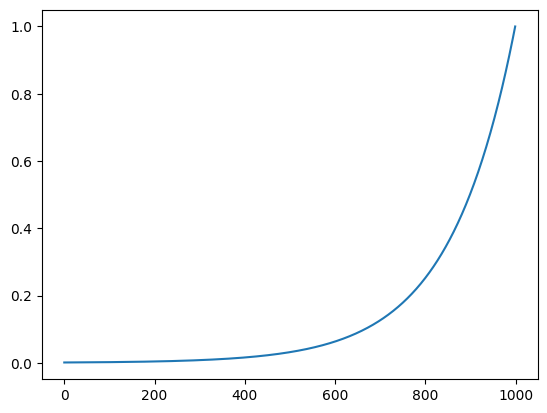

In [183]:
xs = torch.arange(0, 1000, 1)
learning_rates = 10 ** torch.linspace(-3, 0, 1000)
plt.plot(xs, learning_rates)

In [186]:
# initialise net

C = torch.randn((27, 2))
embed = C[X]
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    
# training loop

learning_rates_i = []
losses_i = []
    
for i in range(1000):
    ix = torch.randint(0, num_examples, (32,))
    
    # forward pass
    embed = C[X[ix]]
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    learning_rate = learning_rates[i]
    for p in parameters:
        p.data += -learning_rate * p.grad
        
    # track stats
    learning_rates_i.append(learning_rate.item())
    losses_i.append(loss.item())

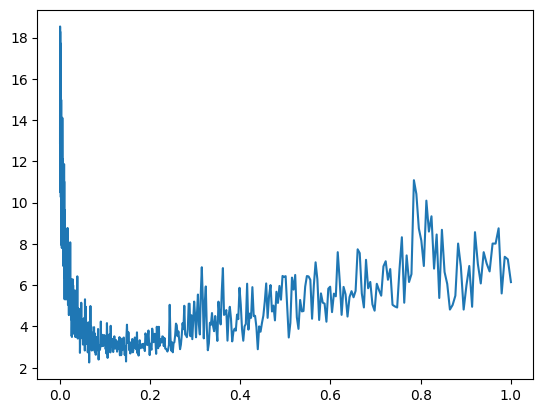

In [187]:
plt.plot(learning_rates_i, losses_i)

Observe that at very low values, the loss stays high. At higher values > 0.2 we see that the loss becomes more unstable. The "sweet spot" here would be around 0.1, at the bottom of the curve.

Let's train our neural net with this learning rate and see what loss we get. Remember in part 1 the loss was around 2.45.

In [189]:
# initialise net

C = torch.randn((27, 2))
embed = C[X]
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    
# training loop

for i in range(200000):
    ix = torch.randint(0, num_examples, (32,))
    
    # forward pass
    embed = C[X[ix]]
    h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

In [190]:
embed = C[X[ix]]
h = torch.tanh(embed.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y[ix])
loss

tensor(1.9474, grad_fn=<NllLossBackward0>)

An improvement! Here is a visualiation of the embedding matrices for all characters:

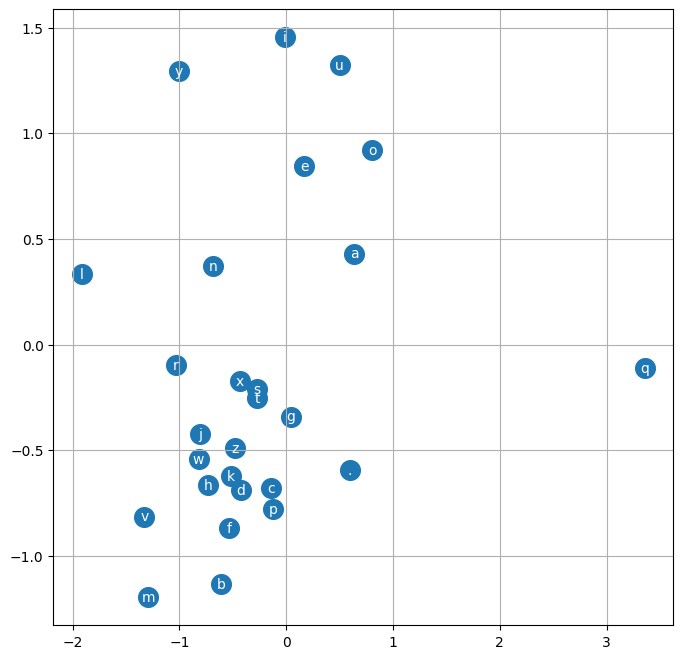

In [191]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

Observe how the nerual net has grouped vowels close together. `q` also appears to be an outlier.

We can sample from the neural net. We feed in the first character (`...`), get our probability distrubtion, and sample from it until we receive an end character.

In [195]:
for _ in range(30):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

baddhita.
ina.
selli.
ira.
nitas.
ipe.
sevaniiseloisliah.
cizaevahxida.
cachianai.
tehiry.
israidei.
ashadhien.
antestionna.
omihan.
badios.
mash.
isa.
isrion.
ediishilistia.
beian.
jhin.
weana.
kaina.
maxabiemina.
darrishi.
cem.
nahayten.
ats.
izai.
iik.
